In [1]:
#  Step 1: Install and Import Libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#  Step 2: Load the Data (upload TBO_4k_train.xlsx)
from google.colab import files
uploaded = files.upload()

df = pd.read_excel(next(iter(uploaded)))
df = df[['text', 'T1 Harmful']].dropna()

Saving TBO_4k_train.xlsx to TBO_4k_train.xlsx


In [3]:
#  Step 3: Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)
    return text

df['text'] = df['text'].apply(clean_text)

In [4]:
#  Step 4: Label Encoding
df['label'] = LabelEncoder().fit_transform(df['T1 Harmful'])

In [5]:
#  Step 5: Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
y = np.array(df['label'])

In [6]:
#  Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#  Step 7: Build the Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
#  Step 8: Train the Model (5 Epochs)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 496ms/step - accuracy: 0.6542 - loss: 0.6484 - val_accuracy: 0.7138 - val_loss: 0.5522
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.7620 - loss: 0.4938 - val_accuracy: 0.7300 - val_loss: 0.5194
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - accuracy: 0.8591 - loss: 0.3216 - val_accuracy: 0.7163 - val_loss: 0.5698
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - accuracy: 0.9340 - loss: 0.1931 - val_accuracy: 0.7038 - val_loss: 0.7247
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 507ms/step - accuracy: 0.9609 - loss: 0.1209 - val_accuracy: 0.6650 - val_loss: 0.9072


In [9]:
#  Step 9: Final Accuracy of Last Epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Epoch Training Accuracy: {final_train_acc:.4f}")
print(f"Final Epoch Validation Accuracy: {final_val_acc:.4f}")

Final Epoch Training Accuracy: 0.9578
Final Epoch Validation Accuracy: 0.6650


In [10]:
#  Step 10: Evaluate on Test Set
loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6823 - loss: 0.8915
Test Accuracy: 0.6650


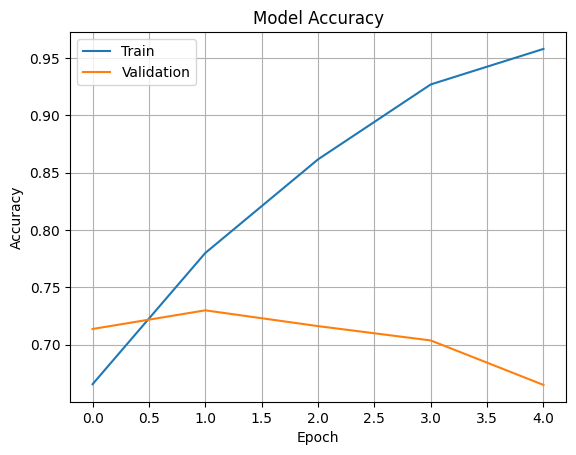

In [11]:
#  Step 11: Plot Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [12]:
#  Step 12: Predict Sample
sample_text = ["You're disgusting and should be banned."]
cleaned = [clean_text(t) for t in sample_text]
seq = tokenizer.texts_to_sequences(cleaned)
padded = pad_sequences(seq, maxlen=max_length, padding='post')
prediction = model.predict(padded)[0][0]
print(f"Predicted Harmful Probability: {prediction:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Predicted Harmful Probability: 0.9774
